# Classification with Hidden Markov Models
Running this notebook will:

- load data generated by `01_generate_data.ipynb` from file chosen in setup part
- split data into train and test subsets with chosen ratio
- fit Hidden Markov Models using both AIC and BIC criteria for selection of number of hidden states
- show comparison of number of hidden states in true and fitted models
- run classification on test subset and show results for both AIC and BIC versions in form of confusion matrices
- save results and information about used data filename and split id in pickle file

## Setup

In [27]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import utils

DATA_PICKLE_FILE = "./data/generated_data_1658168584.pkl"
SEARCH_SPACE = list(range(1,6)) # numbers of hidden states to try
SPLIT_ID = 0

In [28]:
def fit_with_known_no_hidden_states(samples: list[np.ndarray], no_hidden_states: int, trials: int) -> hmm.GaussianHMM:
    """Fit GaussianHMM when number of hidden states is known.
    EM Algorithm will stuck in local optima, so it is recommended to try to fit model multiple times 
    and select the one with highest score. Number of iterations is set via `trials` argument.
    """
    lengths = [len(sample) for sample in samples]
    X = np.concatenate(samples)
    best_model = None
    best_score = -np.infty
    for t in range(trials):
        remodel = hmm.GaussianHMM(n_components = no_hidden_states).fit(X, lengths)
        if not remodel.monitor_.converged:
            print(f"Model in trial {t} didn't converge.") 
        score = remodel.score(X)
        if score > best_score:
            best_model = remodel
            best_score = score
    return best_model

def AIC(samples: list[np.ndarray], model: hmm.BaseHMM) -> float:
    """Akaike Information Criterion implemented for Hidden Markov Model."""
    lengths = [len(sample) for sample in samples]
    X = np.concatenate(samples)
    loglik = model.score(X, lengths)
    k = model.n_components
    return 2*k - 2*loglik

def BIC(samples: list[np.ndarray], model: hmm.BaseHMM) -> float:
    """Bayesian Information Criterion implemented for Hidden Markov Model."""
    lengths = [len(sample) for sample in samples]
    X = np.concatenate(samples)
    loglik = model.score(X, lengths)
    k = model.n_components
    n = sum(lengths) # TODO jak to dziala jak to rozbijam na czesci?
    return k*np.log(n) - 2*loglik

def fit_and_compute_criteria(samples: list[np.ndarray], search_space: list[int], trials: int) -> dict:
    """Return dict containing models and corresponding information criteria values."""
    models = [fit_with_known_no_hidden_states(samples, nhs, trials) for nhs in search_space]
    AICs = [AIC(samples, model) for model in models]
    BICs = [BIC(samples, model) for model in models]
    return {"models": models, "AIC": AICs, "BIC": BICs}

def fit_best_model(samples: list[np.ndarray], search_space: list[int], trials: int = 10, criterion: str = "AIC") -> hmm.BaseHMM:
    """Fit hmm.GaussianHMM models for all number of hidden states in `search_space` and return the one selected
    by given criterion."""
    results = fit_and_compute_criteria(samples, search_space, trials)
    best_model_id = np.argmin(results[criterion]) # Information criteria are minimized, not maximized.
    return results["models"][best_model_id]

def classify_sample(X: np.ndarray, fitted_models: list[hmm.BaseHMM]) -> int:
    """Return id of fitted model with best log-likelihood given (one) sample X."""
    scores = [model.score(X) for model in fitted_models]
    return np.argmax(scores)

## Load data and prepare train and test subsets

In [29]:
with open(DATA_PICKLE_FILE, "rb") as f:
    data = pickle.load(f)

data.keys()


dict_keys(['data_filename', 'time_index', 'models_lst', 'labels_df', 'all_X_samples', 'all_Z_samples', 'indices_splits_lst'])

In [30]:
print(data["data_filename"])

data/generated_data_1658168584.pkl


In [31]:
indices_splits_lst = data["indices_splits_lst"]
print(f"Number of created splits: {len(indices_splits_lst)}.")

Number of created splits: 1.


In [32]:
all_X_samples = data["all_X_samples"]
labels_df = data["labels_df"]
current_split = indices_splits_lst[SPLIT_ID]
train_samples_ids = current_split["train_samples_ids"]
test_samples_ids = current_split["test_samples_ids"]

## Fit the models: use both AIC and BIC

In [34]:
fitted_models_AIC = []
fitted_models_BIC = []
for label, sub_df in labels_df.loc[train_samples_ids].groupby("true_label"):
    int_ids = sub_df.index.values.astype('int')
    X = [all_X_samples[id] for id in int_ids]
    fitted_models_AIC.append(fit_best_model(X, SEARCH_SPACE, criterion="AIC"))
    fitted_models_BIC.append(fit_best_model(X, SEARCH_SPACE, criterion="BIC"))
    

### Compare numbers of hidden states fitted and true models

In [35]:
true_models = data["models_lst"]
print("Number of hidden states in model used to generate samples vs fitted model:")
print("label |true k |fitted k (AIC) |fitted k (BIC)")
for i in range(len(fitted_models_AIC)):
    k_true = true_models[i].n_components
    k_fit_AIC = fitted_models_AIC[i].n_components
    k_fit_BIC = fitted_models_BIC[i].n_components
    print(f"{i}     |{k_true}      |{k_fit_AIC}              |{k_fit_BIC}")

Number of hidden states in model used to generate samples vs fitted model:
label |true k |fitted k (AIC) |fitted k (BIC)
0     |2      |2              |2
1     |2      |2              |2
2     |2      |2              |2
3     |1      |2              |1
4     |1      |3              |1
5     |1      |1              |1
6     |5      |5              |5
7     |3      |3              |3
8     |3      |3              |3


BIC seems better than AIC (no overfitting, too many hidden states in HMM is overfitting). 

## Classify test samples

In [36]:
test_df = labels_df.loc[test_samples_ids]
int_ids = test_df.index.values.astype('int')
test_samples = [all_X_samples[id] for id in int_ids]
predictions_AIC = [classify_sample(X, fitted_models_AIC) for X in test_samples]
predictions_BIC = [classify_sample(X, fitted_models_BIC) for X in test_samples]

predictions_df = pd.DataFrame({
    "predicted_label_AIC": predictions_AIC,
    "predicted_label_BIC": predictions_BIC
}, index= test_df.index)

In [37]:
classification_results = test_df.join(predictions_df)
classification_results.head()

,true_label,sample_id,predicted_label_AIC,predicted_label_BIC
1,0,1,0,0
2,0,2,0,0
3,0,3,0,0
4,0,4,0,0
5,0,5,0,0


### Show confusion matrices

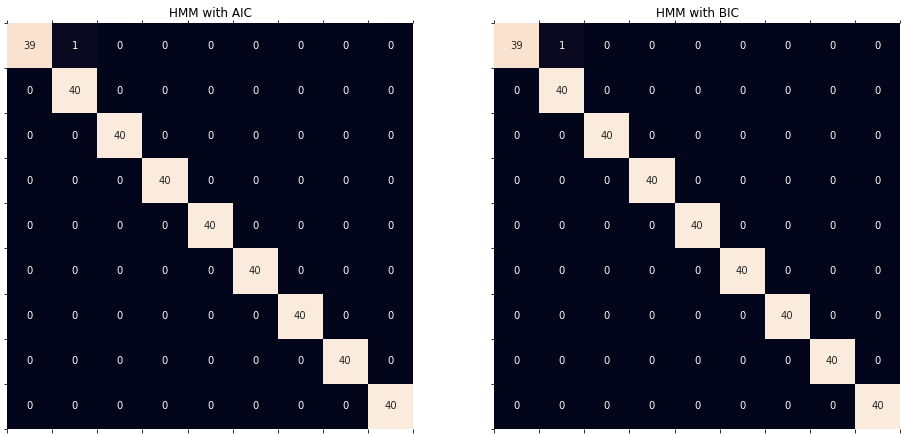

In [38]:
y_true = classification_results["true_label"]
y_pred_AIC = classification_results["predicted_label_AIC"]
y_pred_BIC = classification_results["predicted_label_BIC"]

cm_AIC = confusion_matrix(y_true, y_pred_AIC)
cm_BIC = confusion_matrix(y_true, y_pred_BIC)

plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['font.size'] = 10
fig, axes = plt.subplots(ncols = 2)
sns.heatmap(cm_AIC, annot=True, fmt='g', ax=axes[0], cbar = False)
axes[0].matshow(cm_AIC)
axes[0].set_title("HMM with AIC")
sns.heatmap(cm_BIC, annot=True, fmt='g', ax=axes[1], cbar = False)
axes[1].matshow(cm_BIC)
axes[1].set_title("HMM with BIC")
plt.show()

In [39]:
true = classification_results["true_label"]
for preds_col in classification_results.iloc[:,2:]:
    print(f"{preds_col} accuracy: {utils.accuracy(true, classification_results[preds_col])}")

predicted_label_AIC accuracy: 0.9972222222222222
predicted_label_BIC accuracy: 0.9972222222222222


## Save classification results

In [40]:
time_index = data["time_index"]
summary = {
    "data_filename": DATA_PICKLE_FILE,
    "time_index": time_index,
    "split_id": SPLIT_ID,
    "results_df": classification_results
}

split_id_str = str(SPLIT_ID)
if len(split_id_str) == 1:
    split_id_str = "0" + split_id_str
output_filename = f"./results/hmm_results_{time_index}_{split_id_str}.pkl"
with open(output_filename, 'wb') as f:
    pickle.dump(summary, f)
    print(f"Classification results saved to {output_filename}.")

Classification results saved to ./results/hmm_results_1658168584_00.pkl.
